In [2]:
from quantiles_with_continual_counting import KaryTreeNoise
import numpy as np
import math

def get_slice_parameters(bound: tuple[float, float],
                         m: int,
                         eps: float,
                         beta: float = 0.05,  # Hyperparameter
                         g: float = 1.  # Hyperparameter
                         ) -> int:
    return math.ceil((2 / eps) * np.log(4 * m * (bound[1] - bound[0]) / (g * beta)) - 1)

def binary_tree_max_error(scale: float,
                          delta: float,
                          m: int) -> float:
    """
    Calculate the maximum error bound for a binary tree.

    """
    b_i = np.repeat(scale, m)
    b_M = max(b_i)
    nu = max(np.sqrt(np.sum(b_i ** 2)), b_M * np.sqrt(np.log((2 * m) / delta)))
    return nu * np.sqrt(8 * np.log((2 * m) / delta))

In [12]:
n = 200_000
m_list = range(10, 300, 1)  # number of quantiles
delta_list = [10**-x for x in range(1, 40)]

eps = 1.
eps_cc = eps / 2
eps_mm = eps / 4

min_deltas = []
for m in m_list:
    min_delta = 1  # worst case
    q_list = np.linspace(0, 1, m + 2)[1:-1]
    ranks = [0] + [int(n * q) for q in q_list] + [n]
    eta = min(np.diff(ranks))
    l = get_slice_parameters((0, 2 ** 32 - 1), m, eps_mm)
    bool_update = False
    for delta in delta_list:
        # error using binary tree
        error_bt = binary_tree_max_error(scale=1/eps_cc, delta=delta, m=m)
        # k-ary tree error
        error_k_ary = KaryTreeNoise(eps=eps_cc, max_time=m).high_prob_bound(delta=delta)
        error = min(error_bt, error_k_ary)
        if error < 0.5 * (eta - 1) - l:
            min_delta = delta  # if good, update the minimum delta
        else:
            # take the previous one
            min_deltas.append(delta)
            bool_update = True
            break
    # if not update, append the last one
    if not bool_update:
        min_deltas.append(delta_list[-1])

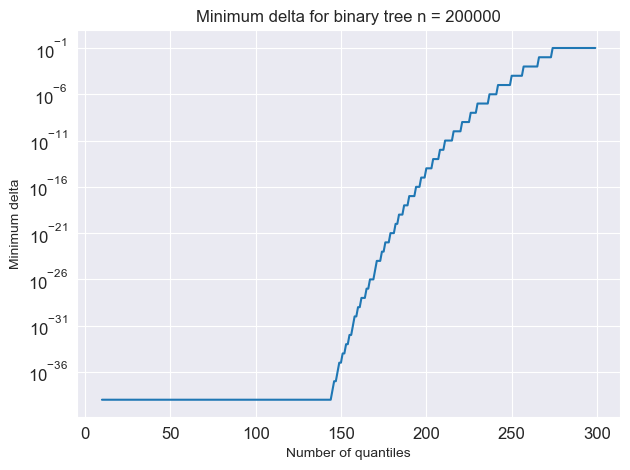

In [13]:
# plot
import matplotlib.pyplot as plt
plt.plot(m_list, min_deltas)
plt.title(f"Minimum delta for binary tree n = {n}")
plt.xlabel("Number of quantiles")
plt.ylabel("Minimum delta")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale("log")
# plot only from [10^-10, 10^-1] y axis
# plt.ylim(10**-20, 10**-1)
plt.tight_layout()

In [19]:
def get_rho(eps: float, delta: float) -> float:
    """
    Convert epsilon to rho with fixed delta.
    :param eps: privacy budget for pure DP
    :param delta: failure probability of pure DP
    """
    return np.sqrt(np.log(1 / delta) + eps) - np.sqrt(np.log(1 / delta))

np.float64(0.059942966679175314)